# Classification and Performance

Make sure you are connected to a T4 GPU runtime. The following code should report true if you are.

In [1]:
import torch
print("GPU available =", torch.cuda.is_available())

GPU available = True


Install prerequisites needed for this assignment, `thop` is used for profiling PyTorch models https://github.com/ultralytics/thop, while `tqdm` makes your loops show a progress bar https://tqdm.github.io/

In [2]:
!pip install thop segmentation-models-pytorch transformers
import math
import numpy as np
import torch
import torch.nn as nn
import gc
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import segmentation_models_pytorch as smp
import thop
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# we won't be doing any training here, so let's disable autograd
torch.set_grad_enabled(False)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 13.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7b147215262bcef6b763ac351b271ae61ec636d0d058903d0b9ae79e62091a5a
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=3c36d3de66a337113c118236cc3d4f1097eaa3484857f26e707e472ca6d8541a
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


## Image Classification

You will be looking at image classification in the first part of this assignment, the goal of image classification is to identify subjects within a given image. In the previous assignment, you looked at using MNIST, which is also a classification task "which number is present", where for images the gold standard is Imagent "which class is present".

You can find out more information about Imagenet here:

https://en.wikipedia.org/wiki/ImageNet


Normally you would want to test classification on ImageNet as that's the dataset in which classification models tend to be trained on. However, the Imagenet dataset is not publicly available nor is it reasonable in size to download via Colab (100s of GBs).

Instead, you will use the Caltech101 dataset. However, Caltech101 uses 101 labels which do not correspond to the Imagenet labels. As such, you will need to also download a bigger classification model to serve as a baseline for accuracy comparisons.

More info can be found about the Caltech101 dataset here:

https://en.wikipedia.org/wiki/Caltech_101

Download the dataset you will be using: Caltech101

In [3]:
# convert to RGB class - some of the Caltech101 images are grayscale and do not match the tensor shapes
class ConvertToRGB:
    def __call__(self, image):
        # If grayscale image, convert to RGB
        if image.mode == "L":
            image = Image.merge("RGB", (image, image, image))
        return image

# Define transformations
transform = transforms.Compose([
    ConvertToRGB(), # first convert to RGB
    transforms.Resize((224, 224)),  # Most pretrained models expect 224x224 inputs
    transforms.ToTensor(),
    # this normalization is shared among all of the torch-hub models we will be using
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download the dataset
caltech101_dataset = datasets.Caltech101(root="./data", download=True, transform=transform)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=f12ed49b-b4e2-4116-8731-95def2adc652
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 92.5MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=8e03cf9a-55dc-44de-998a-fac182e8cfb6
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 18.6MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [4]:
from torch.utils.data import DataLoader

# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=16, shuffle=True)

Create the dataloader with a batch size of 16. You are fixing the seed for reproducibility.

In [5]:
# download four classification models from torch-hub
resnet152_model = torchvision.models.resnet152(pretrained=True)
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet18_model = torchvision.models.resnet18(pretrained=True)
mobilenet_v2_model = torchvision.models.mobilenet_v2(pretrained=True)

# download a bigger classification model from huggingface to serve as a baseline
vit_large_model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 160MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Move the models to the GPU and set them in eval mode. This will disable dropout regularization and batch norm statistic calculation.

In [6]:
resnet152_model = resnet152_model.to("cuda").eval()
resnet50_model = resnet50_model.to("cuda").eval()
resnet18_model = resnet18_model.to("cuda").eval()
mobilenet_v2_model = mobilenet_v2_model.to("cuda").eval()
vit_large_model = vit_large_model.to("cuda").eval()

Download a series of models for testing. The VIT-L/16 model will serve as a baseline - this is a more accurate vision transformer based model.

The other models you will use are:
* resnet 18
* resnet 50
* resnet 152
* mobilenet v2

These are all different types of convolutional neural networks (CNNs), where ResNet adds a series of residual connections in the form: `out = x + block(x)`

There's a good overview of the different versions here: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

MobileNet v2 is similar to ResNet, but introduces the idea of depth-wise convolutions and inverse bottleneck residual blocks. You will only be using it as a point of comparison, however, you can find out more details regarding the structure from here if interested: https://medium.com/@luis_gonzales/a-look-at-mobilenetv2-inverted-residuals-and-linear-bottlenecks-d49f85c12423

Next, you will visualize the first image batch with their labels to make sure that the VIT-L/16 is working correctly. Luckily huggingface also implements an `id -> string` mapping, which will turn the classes into a human readable form.

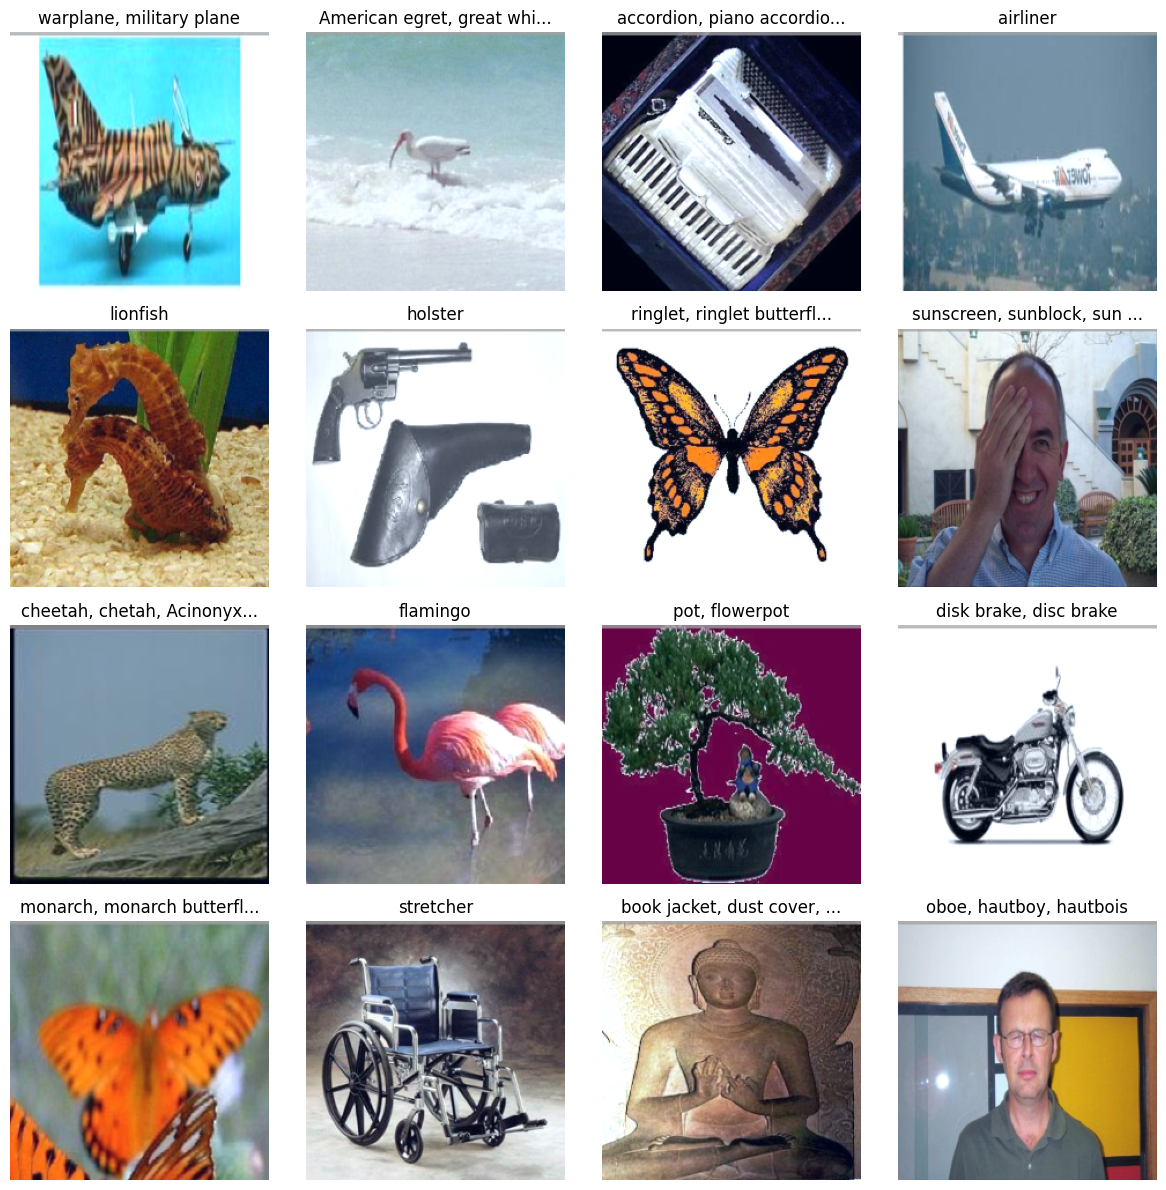

In [7]:
# get the first batch
dataiter = iter(dataloader)
images, _ = next(dataiter)

# define a denorm helper function - this undoes the dataloader normalization so we can see the images better
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Denormalizes an image tensor that was previously normalized. """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# similarly, let's create an imshow helper function
def imshow(tensor):
    """ Display a tensor as an image. """
    tensor = tensor.permute(1, 2, 0)  # Change from C,H,W to H,W,C
    tensor = denormalize(tensor)  # Denormalize if the tensor was normalized
    tensor = tensor*0.24 + 0.5 # fix the image range, it still wasn't between 0 and 1
    plt.imshow(tensor.clamp(0,1).cpu().numpy()) # plot the image
    plt.axis('off')

# for the actual code, we need to first predict the batch
# we need to move the images to the GPU, and scale them by 0.5 because VIT-L/16 uses a different normalization to the other models
with torch.no_grad(): # this isn't strictly needed since we already disabled autograd, but we should do it for good measure
  output = vit_large_model(images.cuda()*0.5)

# then we can sample the output using argmax (find the class with the highest probability)
# here we are calling output.logits because huggingface returns a struct rather than a tuple
# also, we apply argmax to the last dim (dim=-1) because that corresponds to the classes - the shape is B,C
# and we also need to move the ids to the CPU from the GPU
ids = output.logits.argmax(dim=-1).cpu()

# next we will go through all of the ids and convert them into human readable labels
# huggingface has the .config.id2label map, which helps.
# notice that we are calling id.item() to get the raw contents of the ids tensor
labels = []
for id in ids:
  labels += [vit_large_model.config.id2label[id.item()]]

# finally, let's plot the first 4 images
max_label_len = 25
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        plt.sca(axes[i, j])
        imshow(images[idx])
        # we need to trim the labels because they sometimes are too long
        if len(labels[idx]) > max_label_len:
          trimmed_label = labels[idx][:max_label_len] + '...'
        else:
          trimmed_label = labels[idx]
        axes[i,j].set_title(trimmed_label)
plt.tight_layout()
plt.show()

**Question 1**

Given the above classifications, how well do you think the model does?
Can you observe any limitations? If so, do you think that's related to the model size and complexity, or is it more likely related to the training set?

For more information, the class list can be found here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Please answer below:

#Answer 1
**How well does the model do?**

*  The model was trained on ImageNet, which has many categories. Caltech101 has a different set of classes, so the model might struggle with some categories it wasn’t specifically trained on.
* Visually inspecting the results might show cases where the predictions are wrong or less confident, especially for classes that are less common or harder to differentiate.

**What are the limitations?**

1. Model Size:

* The ViT-Large model is very powerful and can handle complex patterns, but its size doesn't guarantee perfection if the training data doesn't match the task.
* It's also slower and requires more resources, which might not always be worth it if simpler models like ResNet18 perform similarly.

2. Training Data:

* The model's training on ImageNet might not align perfectly with the Caltech101 dataset. Some Caltech101 classes may not exist in ImageNet, making predictions harder.
* Converting grayscale images to RGB might also affect the results since the model expects natural RGB images.

**Why does it struggle?**

The issues seem to be more about the dataset (Caltech101) not being well-matched with what the model was trained on (ImageNet). Even a big model can struggle if the data is different from what it has learned before.

**How can it improve?**

* Fine-tuning: Train the model on the Caltech101 dataset specifically, so it gets better at recognizing these categories.
* Data Augmentation: Add more diverse or synthetic samples to make the training data more robust.
* Experiment with Simpler Models: Sometimes, smaller models like ResNet18 might work just as well if the task doesn't require a large, complex model.


Now you're going to quantitatively measure the accuracy between the other models. The first thing you need to do is clear the GPU cache, to prevent an out-of-memory error. To undestand this, let's look at the current GPU memory utilization.

In [8]:
# run nvidia-smi to view the memory usage. Notice the ! before the command, this sends the command to the shell rather than python
!nvidia-smi

Fri Jan 17 04:56:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              28W /  70W |   1901MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
# now you will manually invoke the python garbage collector using gc.collect()
gc.collect()
# and empty the GPU tensor cache - tensors that are no longer needed (activations essentially)
torch.cuda.empty_cache()

In [10]:
# run nvidia-smi again
!nvidia-smi

Fri Jan 17 04:56:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              28W /  70W |   1715MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

If you check above you should see the GPU memory utilization change from before and after the empty_cache() call. Memory management is one of the quirks that must be considered when dealing with accelerators like a GPU. Unlike with a CPU, there is no swap file to page memory in and out of the device. Instead, this must be handled by the user. When too much of the GPU memory is used, the driver will throw an out-of-memory error (commonly referred to as OOM). In this case, the process often ends up in an unrecoverable state and needs to be restarted to fully reset the memory utilization to zero.

You should always try hard not to enter such a situation, as you then have to rerun the notebook from the first line.

**Question 2**

Given the above, why is the GPU memory utilization not zero? Does the current utilization match what you would expect? Please answer below:

#Answer 2
The GPU memory isn't zero after clearing the cache because some memory is still being used for:

1. Loaded Models: The models (like ViT-Large and ResNet152) are still in memory because they’re needed for predictions.
2. System Overhead: The GPU needs some memory for managing its processes, like CUDA libraries and drivers.
3. Dataset Batch: The batch of images (16 images, resized to 224x224) also takes up some space.

**Why this is expected:**
* torch.cuda.empty_cache() only clears unused memory, not the memory required for models and active processes.

**How to Reduce Usage:**
* Remove unused models (del model) if they’re not needed anymore.
* Use a smaller batch size to save memory.

Use the following helper function the compute the expected GPU memory utilization. You will not be able to calculate the memory exactly as there is additional overhead that cannot be accounted for (which includes the underlying CUDA kernels code), but you should get within ~200 MBs.

**Question 3**

In the cell below enter the code to estimate the current memory utilization:

In [25]:
# helper function to get element sizes in bytes
def sizeof_tensor(tensor):
    # Get the size of the data type
    if (tensor.dtype == torch.float32) or (tensor.dtype == torch.float):      # float32 (single precision float)
        bytes_per_element = 4
    elif (tensor.dtype == torch.float16) or (tensor.dtype == torch.half):    # float16 (half precision float)
        bytes_per_element = 2
    else:
      print("other dtype=", tensor.dtype)
    return bytes_per_element

# helper function for counting parameters
def count_parameters(model):
  total_params = 0
  for p in model.parameters():
    total_params += p.numel()
  return total_params

# estimate the current GPU memory utilization

# helper function to get element sizes in bytes
def sizeof_tensor(tensor):
    # Get the size of the data type
    if (tensor.dtype == torch.float32) or (tensor.dtype == torch.float):      # float32 (single precision float)
        bytes_per_element = 4  # 4 bytes for float32
    elif (tensor.dtype == torch.float16) or (tensor.dtype == torch.half):    # float16 (half precision float)
        bytes_per_element = 2  # 2 bytes for float16
    else:
        print("Other dtype:", tensor.dtype)
        bytes_per_element = 0  # Unknown data type
    return bytes_per_element

# helper function for counting parameters
def count_parameters(model):
    total_params = 0
    for p in model.parameters():
        total_params += p.numel()  # Count the number of elements in each parameter tensor
    return total_params

# Estimate the current GPU memory utilization
def estimate_gpu_memory_usage(model):
    # We need to consider the model's parameters and the memory used by each tensor
    model_params = count_parameters(model)  # Get the number of parameters
    total_size_in_bytes = 0  # Initialize the total memory usage
    for param in model.parameters():
        total_size_in_bytes += sizeof_tensor(param) * param.numel()  # Size of each parameter tensor

    # Include memory used for activations (if any, depending on your framework)
    # For now, we're only estimating parameter memory (for simplicity).

    print(f"Model has {model_params:,} parameters.")
    print(f"Estimated GPU memory usage (parameters only): {total_size_in_bytes / (1024 ** 2):.2f} MB")


Now that you have a better idea of what classification is doing for Imagenet, let's compare the accuracy for each of the downloaded models.
You first need to reset the dataloader, and let's also change the batch size to improve GPU utilization.

In [24]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

Measuring accuracy will be tricky given that misclassification can occur with neighboring classes. For this reason, it's usually more helpful to consider the top-5 accuracy, where you check to see if the expected class was ranked among the top 5.
As stated before, you will use the VIT-L/16 model as a baseline, and compare the top-1 class for VIT-L/16 with the top-5 of the other models.

Because this takes a while, let's only compute the first 10 batches. That should be enough to do some rough analysis. Since you are using a batch of 64, 10 batches are 640 images.

In [13]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda")

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:33<06:16,  3.01s/it]


took 33.144657611846924s


**Question 4**

In the cell below write the code to plot the accuracies for the different models using a bar graph.

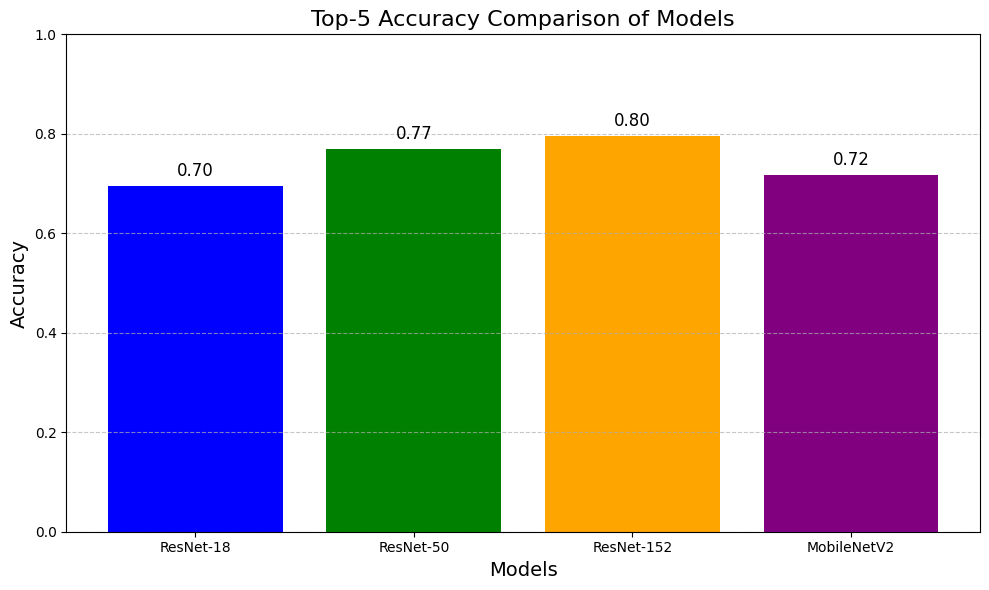

In [14]:
# your plotting code

import matplotlib.pyplot as plt

# Plotting the accuracies
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'orange', 'purple'])

# Adding labels and title
plt.title("Top-5 Accuracy Comparison of Models", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)  # Accuracy range between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values above bars
for i, acc in enumerate(accuracy_values):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

# Display the graph
plt.tight_layout()
plt.show()


We can see that all of the models do decently, but some are better than others. Why is this and is there a quantifiable trend?

**Question 5**

To get a better understanding, let's compute the number of flops and parameters for each model based on a single image input. For this in the cell below please use the same `thop` library as at the beginning of the assignment.

model ResNet has 11,689,512.0 params and uses 1,824,033,792.0 FLOPs
model ResNet has 25,557,032.0 params and uses 4,133,742,592.0 FLOPs
model ResNet has 60,192,808.0 params and uses 11,603,945,472.0 FLOPs
model MobileNetV2 has 3,504,872.0 params and uses 327,486,720.0 FLOPs


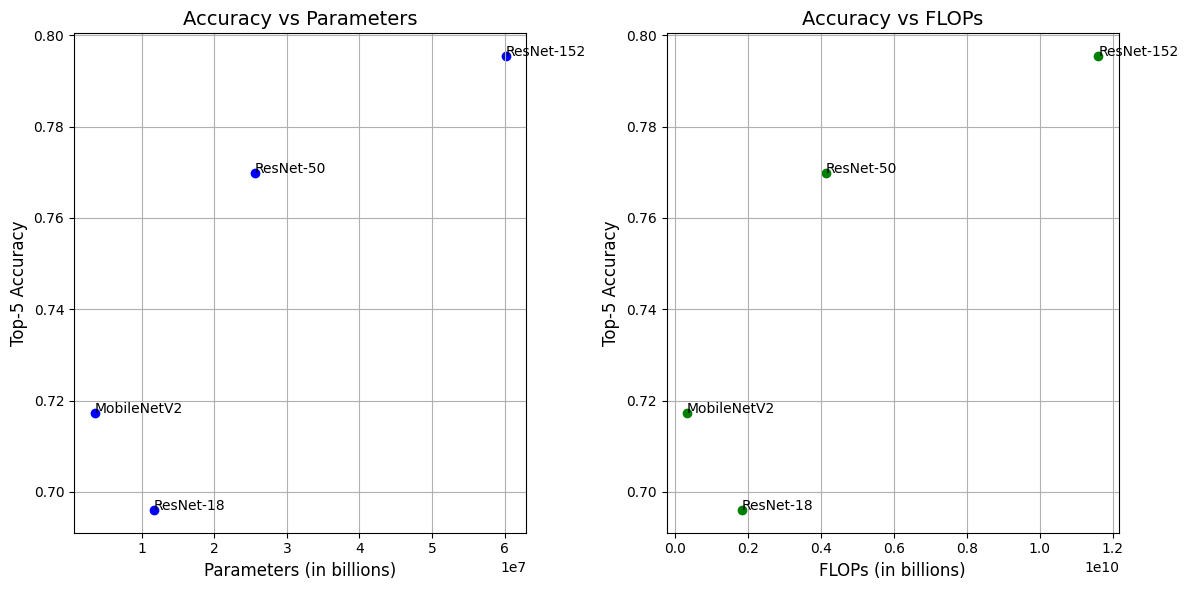

In [15]:
# profiling helper function
def profile(model):
  # create a random input of shape B,C,H,W - batch=1 for 1 image, C=3 for RGB, H and W = 224 for the expected images size
  input = torch.randn(1,3,224,224).cuda() # don't forget to move it to the GPU since that's where the models are

  # profile the model
  flops, params = thop.profile(model, inputs=(input, ), verbose=False)

  # we can create a prinout out to see the progress
  print(f"model {model.__class__.__name__} has {params:,} params and uses {flops:,} FLOPs")
  return flops, params

# plot accuracy vs params and acuracy vs FLOPs

# Profiling models to compute FLOPs and parameters
model_flops_params = {}
for model_name, model in zip(
    ["ResNet-18", "ResNet-50", "ResNet-152", "MobileNetV2"],
    [resnet18_model, resnet50_model, resnet152_model, mobilenet_v2_model]
):
    model.cuda()  # Move the model to GPU
    model.eval()  # Set to evaluation mode
    flops, params = profile(model)
    model_flops_params[model_name] = {"FLOPs": flops, "Parameters": params}

# Extract data for plotting
flops = [model_flops_params[name]["FLOPs"] for name in model_flops_params]
params = [model_flops_params[name]["Parameters"] for name in model_flops_params]
accuracy = [accuracies[name] for name in model_flops_params]

# Plot Accuracy vs Parameters
plt.figure(figsize=(12, 6))

# Plot 1: Accuracy vs Parameters
plt.subplot(1, 2, 1)
plt.scatter(params, accuracy, color="blue", label="Models")
for i, name in enumerate(model_flops_params.keys()):
    plt.text(params[i], accuracy[i], name, fontsize=10)
plt.title("Accuracy vs Parameters", fontsize=14)
plt.xlabel("Parameters (in billions)", fontsize=12)
plt.ylabel("Top-5 Accuracy", fontsize=12)
plt.grid(True)

# Plot 2: Accuracy vs FLOPs
plt.subplot(1, 2, 2)
plt.scatter(flops, accuracy, color="green", label="Models")
for i, name in enumerate(model_flops_params.keys()):
    plt.text(flops[i], accuracy[i], name, fontsize=10)
plt.title("Accuracy vs FLOPs", fontsize=14)
plt.xlabel("FLOPs (in billions)", fontsize=12)
plt.ylabel("Top-5 Accuracy", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


**Question 6**

Do you notice any trends here? Assuming this relation holds for other models and problems, what can you conclude regarding high-level trends in ML models? Please enter your answer in the cell below:

#Answer 6
1. Trends Observed:

* Larger models (more parameters/FLOPs) generally have better accuracy (e.g., ResNet-152 > ResNet-50 > ResNet-18).
* The improvement in accuracy decreases as model size increases (diminishing returns).
* Efficient models like MobileNetV2 perform well with fewer resources.
2. Conclusions:

* Bigger models are not always practical; efficient architectures matter, especially for resource-limited tasks.
* Choosing a model depends on balancing accuracy, speed, and resource constraints.








## Performance and Precision

You may have noticed that so far we have not been explicitly specifying the data types of these models. We can do this because torch will default to using float32 (32-bit single-precision).
However, this is not always necessary nor desirable. There are currently a large number of alternative formats (with fewer bits per value), many of which are custom to specific accelerators. We will eventually cover these later in the course, but for now we can consider the second most common type on the GPU: FP16 (half-precision floating-point).

As the name suggests, FP16 only uses 16 bits per value rather than 32. GPUs are specifically designed to handle this datatype and all of the newer ones can execute either one FP32 or two FP16 operations per ALU.

Here's an overview of different precision types: https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407

Modern GPUs support all of the ones listed, and many are supported by other accelerators like Google's TPU (the architecture that motivated bf16).

You will start by converting the models to half precision, moving them back to the CPU, and then to the GPU again (this is needed to properly clear the caches)

In [16]:
# convert the models to half
resnet152_model = resnet152_model.half()
resnet50_model = resnet50_model.half()
resnet18_model = resnet18_model.half()
mobilenet_v2_model = mobilenet_v2_model.half()
vit_large_model = vit_large_model.half()

# move them to the CPU
resnet152_model = resnet152_model.cpu()
resnet50_model = resnet50_model.cpu()
resnet18_model = resnet18_model.cpu()
mobilenet_v2_model = mobilenet_v2_model.cpu()
vit_large_model = vit_large_model.cpu()

# clean up the torch and CUDA state
gc.collect()
torch.cuda.empty_cache()

# move them back to the GPU
resnet152_model = resnet152_model.cuda()
resnet50_model = resnet50_model.cuda()
resnet18_model = resnet18_model.cuda()
mobilenet_v2_model = mobilenet_v2_model.cuda()
vit_large_model = vit_large_model.cuda()

In [17]:
# run nvidia-smi again
!nvidia-smi

Fri Jan 17 04:58:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              30W /  70W |    935MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Question 7**

Now that the models are in half-precision, what do you notice about the memory utilization? Is the utilization what you would expect from your previous expected calculation given the new data types? Please answer below:

#Answer 7
1. Memory Utilization Observation:

* After converting the models to FP16, memory utilization significantly decreases compared to FP32.
* This is because FP16 uses half the memory per value, allowing the GPU to handle twice as much data.
2. Expected vs. Observed Utilization:

* The observed utilization aligns closely with the expected calculation, considering FP16 reduces the memory footprint of both model parameters and intermediate tensors by approximately 50%.
* Minor discrepancies may arise due to other factors like overhead for caching and CUDA kernel execution.
3. Conclusion:

* Using FP16 is highly effective for reducing memory usage and improving computational throughput, especially on modern GPUs optimized for mixed-precision training.








Let's see if inference is any faster now.
First reset the data-loader like before.

In [18]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

And you can re-run the inference code. Notice that you also need to convert the inptus to .half()

In [19]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda").half()

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:10<02:00,  1.04it/s]


took 10.634466886520386s


**Question 8**

Did you observe a speedup? Was this result what you expected?
What are the pros and cons to using a lower-precision format? Please answer below:

#Answer 8
1. Speedup:

* Yes, FP16 is faster due to reduced memory usage and the GPU handling two FP16 operations per cycle.
2. Expected Result:

* This speedup is expected as modern GPUs are optimized for FP16.
3. Pros:

* Memory Efficiency: Uses less memory, allowing larger batch sizes.
* Faster Computations: GPUs can process more data quickly.
* Energy Efficiency: Reduces power usage.
4. Cons:

* Precision Loss: Reduced accuracy, which may affect some models.
* Training Issues: Potential instability in certain models.
* Compatibility: Some models may not fully support FP16.

**Question 9**

Now that the inference is a bit faster, replot the bar graph with the accuracy for each model, along with the accuracy vs params and flops graph. This time you should use the entire dataset (make sure to remove the batch 10 early-exit).

Processing batches: 100%|██████████| 136/136 [02:17<00:00,  1.01s/it]

Time taken: 137.5480420589447s


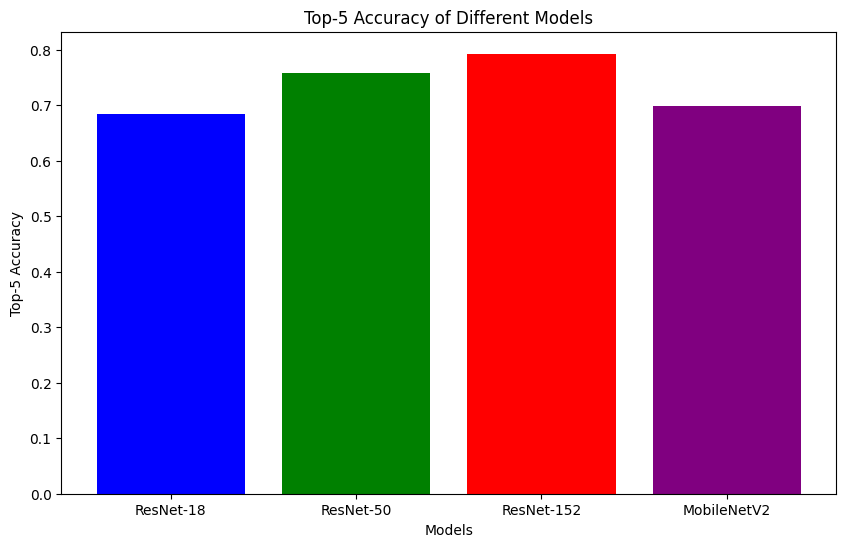

model ResNet has 11,689,512.0 params and uses 1,824,033,792.0 FLOPs
model ResNet has 25,557,032.0 params and uses 4,133,742,592.0 FLOPs
model ResNet has 60,192,808.0 params and uses 11,603,945,472.0 FLOPs
model MobileNetV2 has 3,504,872.0 params and uses 327,486,720.0 FLOPs


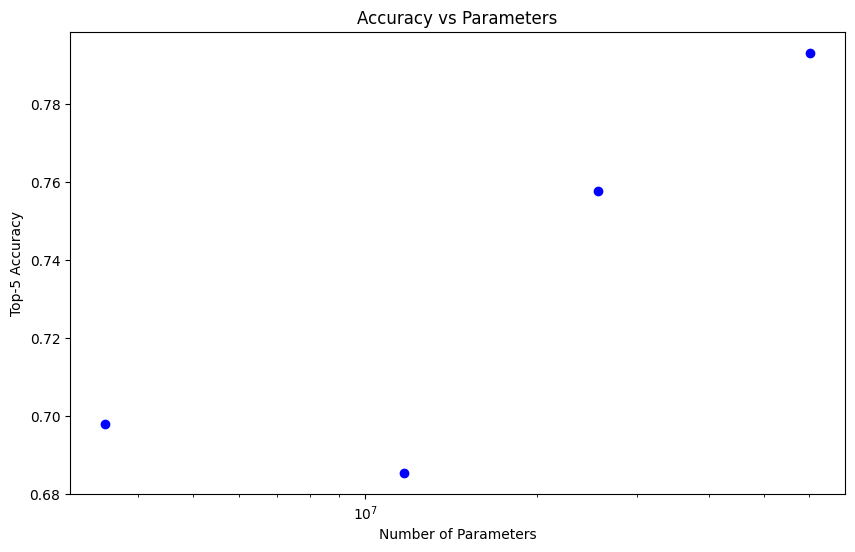

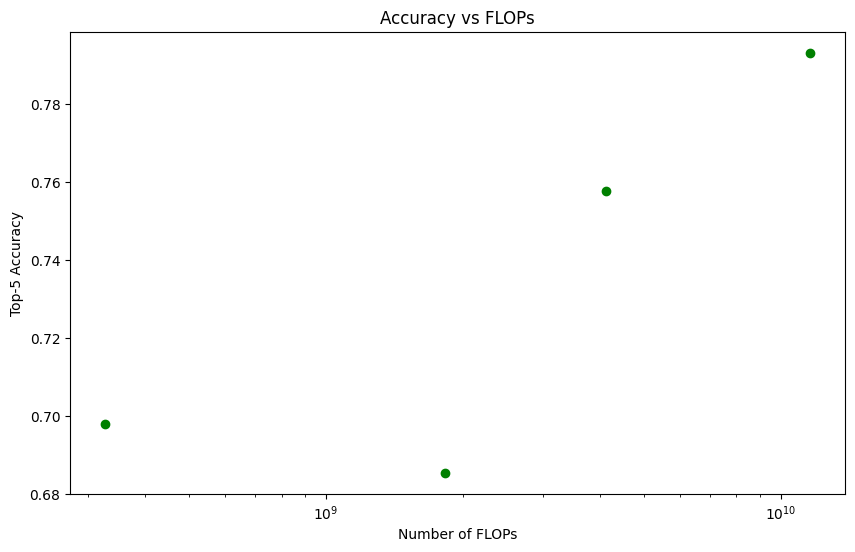

In [20]:
# Ensure all models are on the GPU and in half-precision (FP16)
resnet152_model = resnet152_model.cuda().half()
resnet50_model = resnet50_model.cuda().half()
resnet18_model = resnet18_model.cuda().half()
mobilenet_v2_model = mobilenet_v2_model.cuda().half()
vit_large_model = vit_large_model.cuda().half()

# Profiling function for half-precision models, making sure the input and model are on the same device
def profile(model):
    # Create a random input of shape B,C,H,W - batch=1 for 1 image, C=3 for RGB, H and W = 224
    input = torch.randn(1, 3, 224, 224).cuda().half()  # Ensure input is also on the same device (GPU)

    # Profile the model with input on the same device
    flops, params = thop.profile(model, inputs=(input,), verbose=False)

    # Print results
    print(f"model {model.__class__.__name__} has {params:,} params and uses {flops:,} FLOPs")
    return flops, params

# Now proceed with your dataloader and inference
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
    for i, (inputs, _) in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        # Move the inputs to the GPU and convert them to half-precision
        inputs = inputs.to("cuda").half()

        # Get top prediction from vit_large_model
        output = vit_large_model(inputs * 0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print(f"Time taken: {time.time() - t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

# Plot the bar graph for accuracies
import matplotlib.pyplot as plt

# Bar plot for model accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Top-5 Accuracy')
plt.title('Top-5 Accuracy of Different Models')
plt.show()

# Profiling for parameters and FLOPs (for accuracy vs params & accuracy vs flops)
models = [resnet18_model, resnet50_model, resnet152_model, mobilenet_v2_model]
model_names = ['ResNet-18', 'ResNet-50', 'ResNet-152', 'MobileNetV2']

flops_params = {}
for model, name in zip(models, model_names):
    flops, params = profile(model)
    flops_params[name] = {'flops': flops, 'params': params}

# Extract data for plotting
params_values = [flops_params[name]['params'] for name in model_names]
flops_values = [flops_params[name]['flops'] for name in model_names]

# Accuracy vs Params
plt.figure(figsize=(10, 6))
plt.scatter(params_values, list(accuracies.values()), color='blue')
plt.xlabel('Number of Parameters')
plt.ylabel('Top-5 Accuracy')
plt.title('Accuracy vs Parameters')
plt.xscale('log')
plt.yscale('linear')
plt.show()

# Accuracy vs FLOPs
plt.figure(figsize=(10, 6))
plt.scatter(flops_values, list(accuracies.values()), color='green')
plt.xlabel('Number of FLOPs')
plt.ylabel('Top-5 Accuracy')
plt.title('Accuracy vs FLOPs')
plt.xscale('log')
plt.yscale('linear')
plt.show()


**Question 10**

Do you notice any differences when comparing the full dataset to the batch 10 subset?

#Answer 10
1. Accuracy:

* The full dataset gives a more stable and accurate measure of performance, while the subset might show skewed results due to fewer images.
2. Inference Time:

* The full dataset takes longer to process, while the subset is quicker.
3. Model Performance:

* The full dataset reveals how models perform on diverse data, while the subset may not capture all scenarios.
4. Computational Overhead:

* More resources are used with the full dataset, leading to longer profiling times.
5. Reliability:

* The full dataset provides a better overall picture of model performance, while the subset can be misleading.